In [2]:
import os

import xarray as xr
import rioxarray as rioxr
import rasterio
import rasterio.plot

import numpy as np
import matplotlib.pyplot as plt

from rioxarray.merge import merge_arrays
from glob import glob

In [3]:
lower_left_lon = -141.899414
lower_left_lat = 47.783635
upper_right_lon = -112.104492
upper_right_lat = 60.866312
bbox = [lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat]

In [25]:
try:
    os.makedirs('mosaic')
except:
    pass

In [24]:
dates = glob(os.path.join('modis','*'))
for date in dates:
    file_pths = glob(os.path.join(date,'*'))
    src_files = []
    for f_pth in file_pths:
        print(f_pth)
        with rioxr.open_rasterio(f_pth) as src:
            src_files.append(src.NDSI_Snow_Cover)
    ds = merge_arrays(src_files)
    ds = ds.rio.reproject('EPSG:4326')
    ds = ds.rio.clip_box(*bbox)
    out_pth = os.path.join('mosaic',f'{os.path.split(date)[-1]}.tif')
    ds.rio.to_raster(out_pth, recale_transform=True)

NameError: name 'dates' is not defined

In [22]:
mosaics = glob(os.path.join('mosaic','*'))
ds = xr.Dataset()
for mosaic in mosaics:
    ndsi = rioxr.open_rasterio(mosaic)
    ndsi.data[(ndsi.data > 100)] = 0
    ndsi.data[(ndsi.data < 20)] = 0
    ndsi.data[(ndsi.data != 0)] = 1
    ds[os.path.split(mosaic)[-1]] = ndsi
nds = ds.to_array(dim='mean').mean(dim='mean', skipna=True)
nds.rio.to_raster('mean.tif')

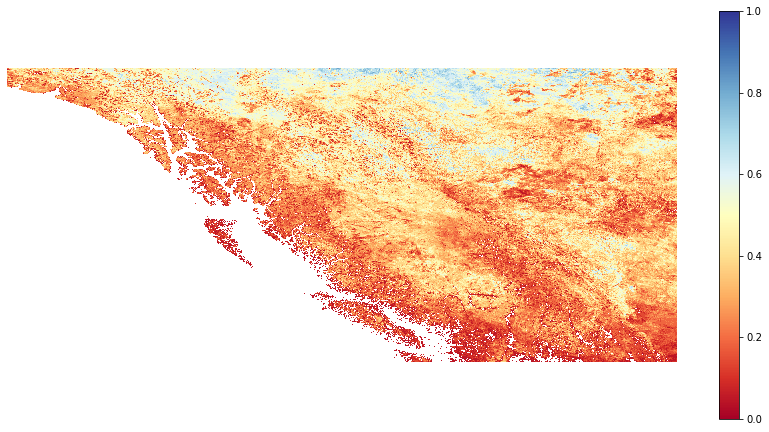

In [32]:
with rioxr.open_rasterio('mean.tif') as src:
    d = src.data
fig, ax = plt.subplots(1,1,figsize=(15,7.5))
ax.axis('off')
d[(d==0)] = np.nan
#ax.set_facecolor('k')
im = ax.imshow(d[0], cmap=plt.cm.RdYlBu, vmin=0, vmax=1, clim=[0,1])
fig.colorbar(im, ax=ax)
plt.savefig('ndsi.jpg', format='jpeg')